# 4章 モデルの訓練
## 環境構築

In [60]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 問題4.12
scikit-learnを使わずに、ソフトマックス回帰のための早期打ち切り機能を持つバッチ勾配降下を実施

In [61]:
#irisのデータで使う
from sklearn import datasets
iris = datasets.load_iris()
X = iris["data"][:,(2,3)] #petal length, width
X_with_bias = np.c_[np.ones([len(X), 1]), X] #バイアス項
print(X.shape, np.ones([len(X), 1]).shape)
y = iris["target"]

(150, 2) (150, 1)


In [62]:
#訓練データと検証データに分ける
np.random.seed(4042)
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

In [63]:
#ターゲットをone-hot表記の配列に変更する
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m,n_classes))
    for i in range(m):
        Y_one_hot[i][y[i]] = 1
    return Y_one_hot

Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [64]:
#ソフトマックス関数の実装
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [65]:
#特徴量の数
n_inputs = X_train.shape[1] #花弁の長さ、幅、バイアス
n_outputs = len(np.unique(y_train)) # 3つの種類


In [66]:
#ソフトマックス
eta = 0.01 #学習率
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta) #学習データとパラメータの内積。これで各クラスのスコアがもとまる。つまり、(1,3)のベクトル
    Y_proba = softmax(logits)
    if iteration % 500 == 0: #500回に一回見れるようにする
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta*gradients
#モデルの確認
print(Theta)

0 1.5443682189148507
500 0.8613766773571236


1000 0.7217783904186448
1500 0.6347579904278986
2000 0.5776216700592327
2500 0.5374212544246391
3000 0.5073157430016453
3500 0.48360801268677744
4000 0.4641946806237085
4500 0.44781131669099905
5000 0.43365802976568524
[[ 3.1232221  -0.61302874 -2.56797112]
 [-1.50814827 -0.16352815 -0.65979253]
 [-1.08429937 -0.63008604  2.08705595]]


In [67]:
#検証誤差を見る
logits = X_valid.dot(Theta) #スコア
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

In [68]:
#ソフトマックス+Ridge回帰
eta = 0.01 #学習率
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1 #Ridge回帰

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta) #学習データとパラメータの内積。これで各クラスのスコアがもとまる。つまり、(1,3)のベクトル
    Y_proba = softmax(logits)
    if iteration % 500 == 0: #500回に一回見れるようにする
        x_entropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:])) #バイアスパラメータは無視
        loss = x_entropy_loss + alpha*l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha*Theta[1:]]
    Theta = Theta - eta*gradients
#モデルの確認
print(Theta)

0 6.588172906404339
500 0.8030305896037832
1000 0.7114555899493128


1500 0.6624197985154344
2000 0.6324850418579613
2500 0.6122572782234159
3000 0.5975943051711189
3500 0.5864410622425491
4000 0.5776611933021578
4500 0.5705697577639497
5000 0.5647264414253517
[[ 2.47318004 -0.6622321  -2.98360154]
 [-0.80460277  0.25385109  0.54638051]
 [-0.39963719 -0.0868442   0.48196038]]


In [69]:
#検証誤差を見る
logits = X_valid.dot(Theta) #スコア
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

In [73]:
#ソフトマックス+Ridge回帰+早期打ち切り
#検証誤差が増えたタイミングで辞める
eta = 0.01 #学習率
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1 #Ridge回帰
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta) #学習データとパラメータの内積。これで各クラスのスコアがもとまる。つまり、(1,3)のベクトル
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha*Theta[1:]]
    Theta = Theta - eta*gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    x_entropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:])) #バイアスパラメータは無視
    loss = x_entropy_loss + alpha*l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!!!")
        break

0 2.037785669926403
500 1.1475864710328008
1000 0.8848679544024616
1500 0.7567031934210611
2000 0.6870834292651892
2500 0.6447207093397171
3000 0.6165641764574942
3500 0.5965893281138536
4000 0.5817157162554163
4500 0.5702276468931247
5000 0.561100993864917


<function matplotlib.pyplot.show(close=None, block=None)>

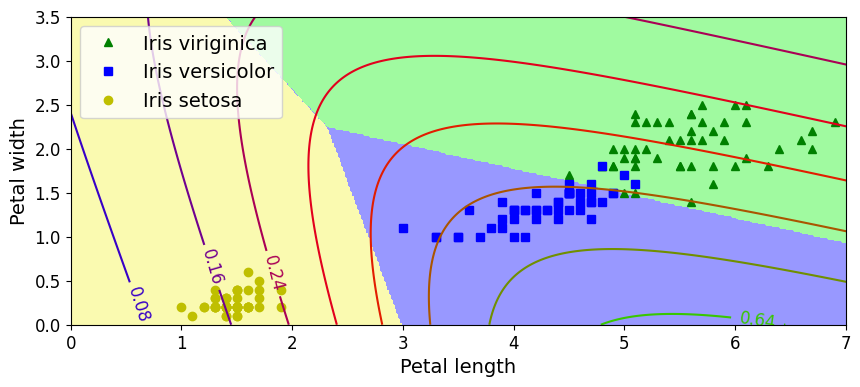

In [84]:
#結果のプロット
x0, x1 = np.meshgrid(np.linspace(0,8,500).reshape(-1,1), np.linspace(0,3.5,200).reshape(-1,1),)
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:,1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10,4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label = "Iris viriginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label = "Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label = "Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc = "upper left", fontsize=14)
plt.axis([0,7,0,3.5])
plt.show
